# Lab 5

## Завантаження даних з файлу lab5.xlsx до датафрейму

In [38]:
import cv2
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import numpy as np
import os
from IPython.display import display, Image as IPImage

file_path = "C:/Users/NikaLina/Python/lab5.xlsx"
df = pd.read_excel(file_path)

## Створити функцію, що приймає в якості аргументів дані з датафрейму та повертає зменшене зображення з доданими «круглими окулярами» та зберігає отримане зображення у файл.

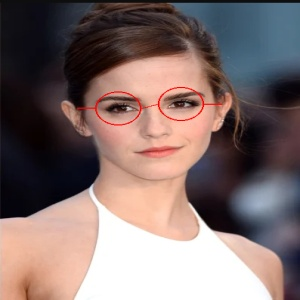

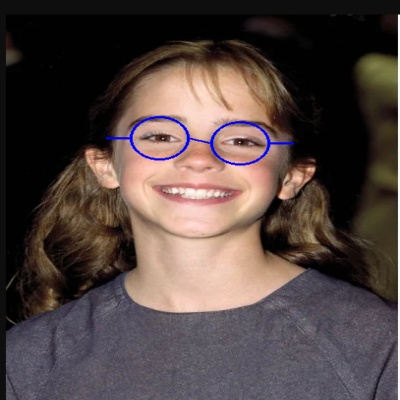

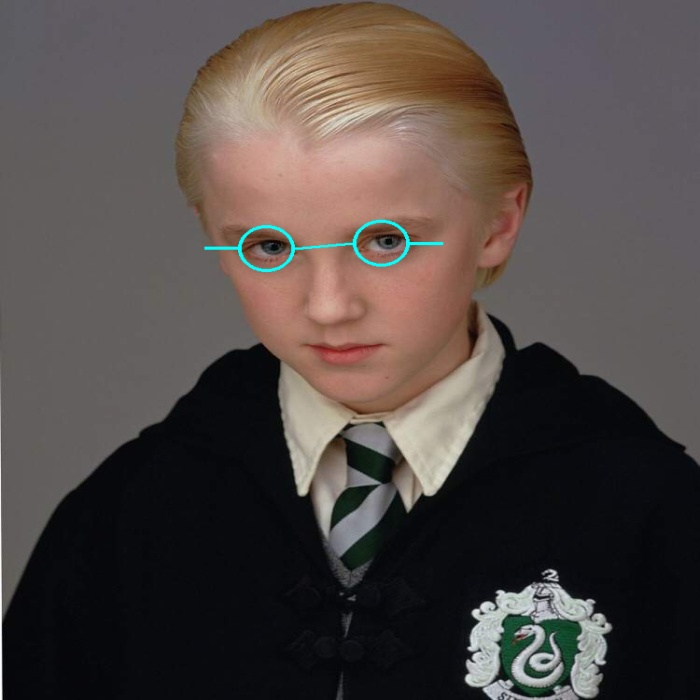

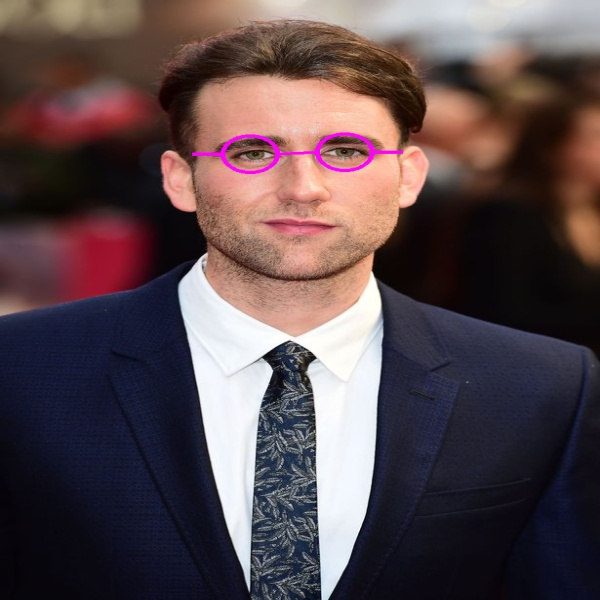

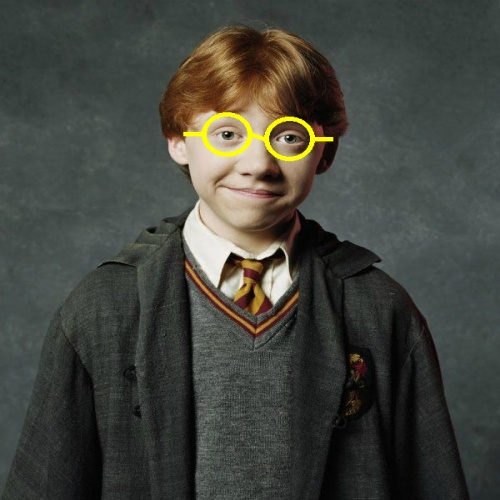

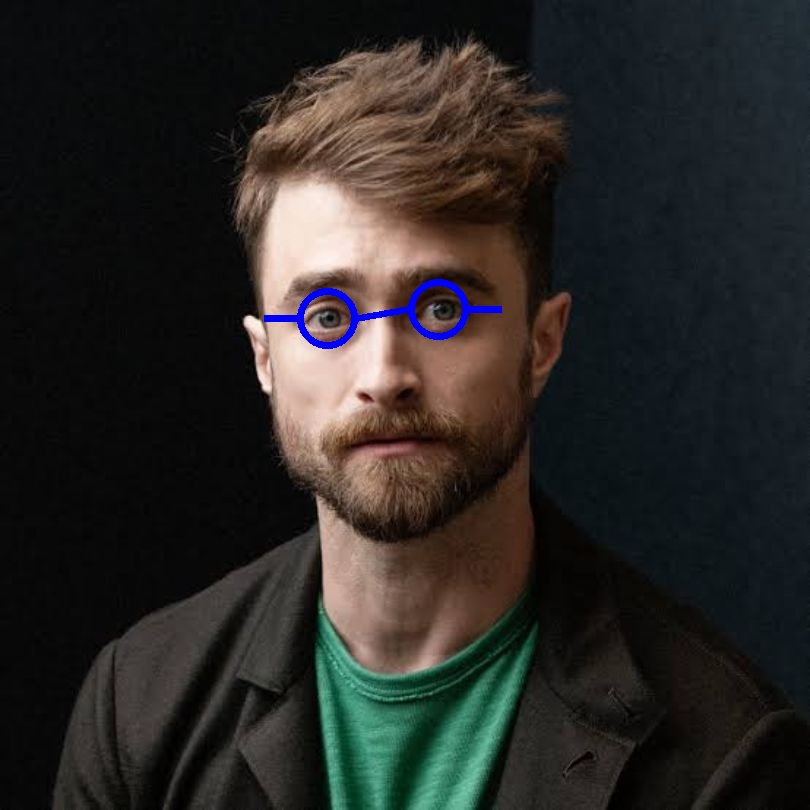

0    None
1    None
2    None
3    None
4    None
5    None
dtype: object

In [40]:
face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
eye_cascade_path = cv2.data.haarcascades + 'haarcascade_eye.xml'

face_cascade = cv2.CascadeClassifier(face_cascade_path)
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

image_folder = "C:/Users/NikaLina/Python/Images/"
output_folder = "C:/Users/NikaLina/Python/ProcessedImages/"
os.makedirs(output_folder, exist_ok=True)

def process_image(row):
    file_name = row['file name']
    image_size = tuple(map(int, row['image size'].split('x')))
    glasses_color = row['glasses color']
    line_width = row['line width']

    img_path = os.path.join(image_folder, file_name)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Image not found: {file_name}")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=10)

        if len(eyes) >= 2:
            eye_centers = [(x + ex + ew // 2, y + ey + eh // 2, ew * eh) for (ex, ey, ew, eh) in eyes]

            eye_centers = sorted(eye_centers, key=lambda c: c[2], reverse=True)[:2]
            if len(eye_centers) == 2:
                left_eye, right_eye = sorted(eye_centers[:2], key=lambda c: c[0])
                if abs(left_eye[1] - right_eye[1]) < h * 0.2:
                    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    draw = ImageDraw.Draw(img_pil)
                    color_rgb = ImageColor.getrgb(glasses_color)

                    for eye in [left_eye, right_eye]:
                        draw.ellipse([
                            (eye[0] - 30, eye[1] - 30),
                            (eye[0] + 30, eye[1] + 30)
                        ], outline=color_rgb, width=line_width)

                    draw.line([
                        (left_eye[0] + 30, left_eye[1]),
                        (right_eye[0] - 30, right_eye[1])
                    ], fill=color_rgb, width=line_width)

                    max_ear_length = int(w * 0.4)
                    ear_length = min(int(0.3 * abs(right_eye[0] - left_eye[0])), max_ear_length)

                    left_ear_end_x = max(x, left_eye[0] - 30 - ear_length)
                    left_ear_end = (left_ear_end_x, left_eye[1])

                    right_ear_end_x = min(x + w, right_eye[0] + 30 + ear_length)
                    right_ear_end = (right_ear_end_x, right_eye[1])

                    draw.line([(left_eye[0] - 30, left_eye[1]), left_ear_end], fill=color_rgb, width=line_width)
                    draw.line([(right_eye[0] + 30, right_eye[1]), right_ear_end], fill=color_rgb, width=line_width)

                    img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
                    resized_img = cv2.resize(img, image_size, interpolation=cv2.INTER_AREA)
                    output_path = os.path.join(output_folder, f"processed_{file_name}")
                    cv2.imwrite(output_path, resized_img)

                    display(IPImage(output_path))
                    return
        print(f"Could not find two aligned eyes in image: {file_name}")

df.apply(process_image, axis=1)
